In [1]:
import numpy as np
import sklearn
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import copy
from sklearn import preprocessing
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings('ignore')
from sklearn.semi_supervised import SelfTrainingClassifier, LabelPropagation, LabelSpreading
from imblearn.over_sampling import SMOTE
import pickle
#import mvlearn
#from mvlearn.semi_supervised import CTClassifier

In [2]:
# load the data
df = pd.read_csv("bank-additional-full.csv",
                 delimiter=";", dtype=str)

In [3]:
# data cleaning
df['y'].replace(['yes', 'no'],[0, 1], inplace=True)
df['job'].replace(['admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown'],[1,2,3,4,5,6,7,8,9,10,11,12], inplace = True)
df['marital'].replace(['divorced','married','single','unknown'],[1,2,3,4],inplace = True)
df['education'].replace(['basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown'],[1,2,3,4,5,6,7,8],inplace = True)
df['default'].replace(['no','yes','unknown'],[0,1,2],inplace = True)
df['housing'].replace(['no','yes','unknown'],[0,1,2],inplace = True)
df['loan'].replace(['no','yes','unknown'],[0,1,2],inplace = True)
df['contact'].replace(['cellular','telephone'],[0,1],inplace = True)
df['month'].replace(['jan', 'feb', 'mar','apr','may','jun','jul','aug','sep','oct','nov','dec'],[1,2,3,4,5,6,7,8,9,10,11,12],inplace = True)
df['day_of_week'].replace(['mon','tue','wed','thu','fri'],[1,2,3,4,5],inplace=True)
df['duration'] = pd.to_numeric(df['duration'])
df['pdays'] = pd.to_numeric(df['pdays'])
df['previous'] = pd.to_numeric(df['previous'])
df['poutcome'].replace(['failure','success','nonexistent'],[1,2,3],inplace=True)
df['emp.var.rate'] = pd.to_numeric(df['emp.var.rate'])
df['cons.price.idx'] = pd.to_numeric(df['cons.price.idx'])
df['cons.conf.idx'] = pd.to_numeric(df['cons.conf.idx'])
df['euribor3m'] = pd.to_numeric(df['euribor3m'])
df['nr.employed'] = pd.to_numeric(df['nr.employed'])

### Data Splitting

In [4]:
df_train, df_test = train_test_split(df, test_size=0.25)
df_train, df_val = train_test_split(df_train, test_size = 0.25)

In [5]:
train_data = df_train.iloc[:,:-1]
train_label = df_train.iloc[:,-1]

val_data = df_val.iloc[:,:-1]
val_label = df_val.iloc[:,-1]

test_data = df_test.iloc[:,:-1]
test_label = df_test.iloc[:,-1]

In [6]:
#Converting supervised data to semi supervised dataset
train_labelled, train_unlabelled = train_test_split(df_train, test_size=0.8)
train_data = train_labelled.iloc[:,:-1]
train_label = train_labelled.iloc[:,-1]
train_unlabelled = train_unlabelled.drop(columns = ['y'])

In [7]:
log_reg = LogisticRegression(penalty = 'none',fit_intercept=True,max_iter = 100)
log_reg.fit(train_data,train_label)
val_pred_log_reg = log_reg.predict(val_data)
accuracy_score(val_label,val_pred_log_reg)

0.9037938624886702

In [8]:
t1 = train_data.drop(columns=['nr.employed','emp.var.rate','cons.price.idx'])
log_reg = LogisticRegression(penalty = 'none',fit_intercept=True,max_iter = 100)
log_reg.fit(t1,train_label)
val_pred_log_reg = log_reg.predict(val_data.drop(columns=['nr.employed','emp.var.rate','cons.price.idx']))
accuracy_score(val_label,val_pred_log_reg)

0.9037938624886702

<AxesSubplot:>

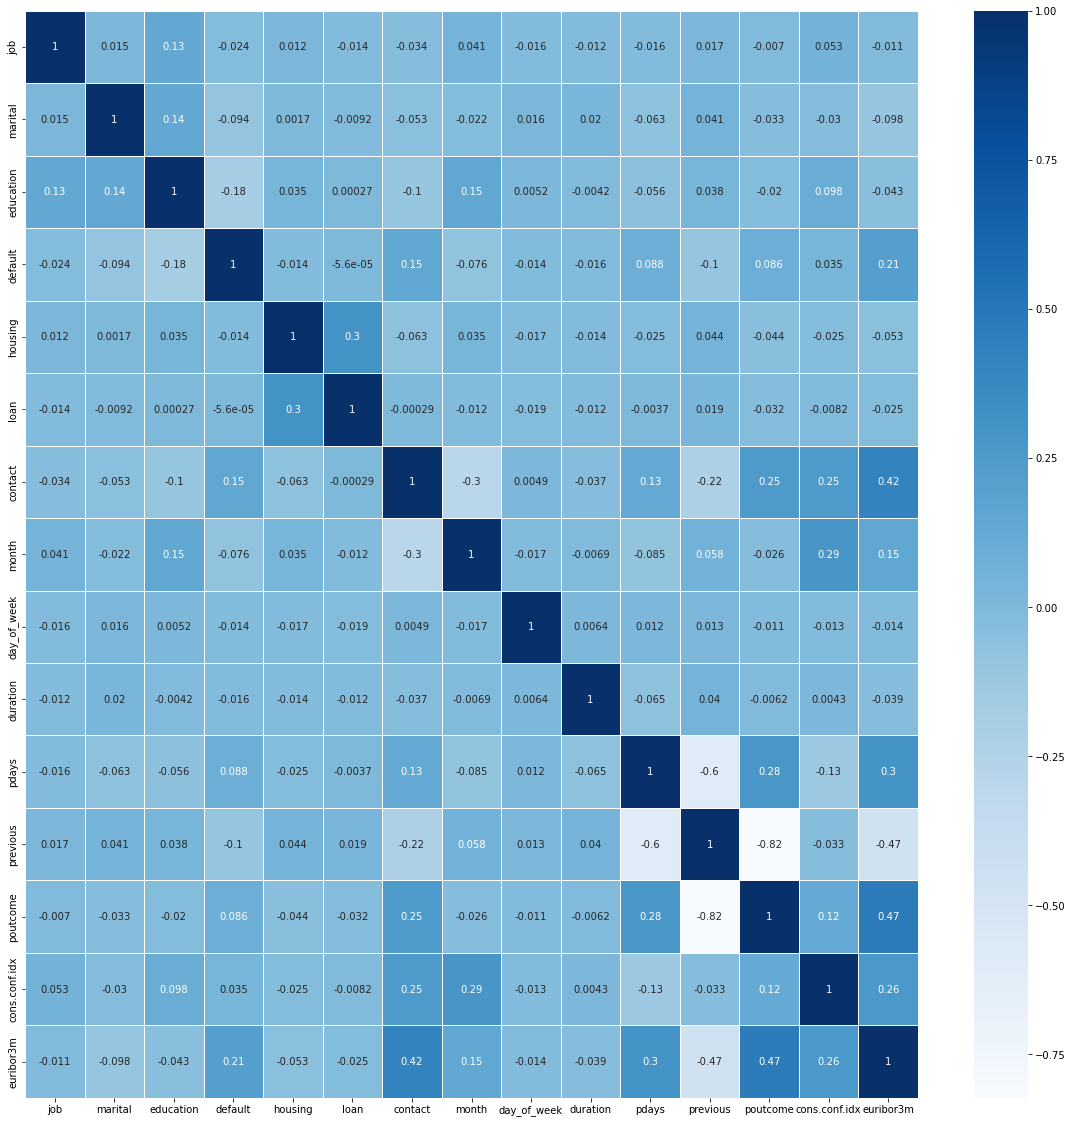

In [9]:
plt.figure(figsize=(20,20))
sns.heatmap(t1.corr(),annot=True,cmap='Blues',linewidths=.5)

In [10]:
train_data = train_data.drop(columns = ['nr.employed','emp.var.rate','cons.price.idx'])
train_unlabelled = train_unlabelled.drop(columns = ['nr.employed','emp.var.rate','cons.price.idx'])
val_data = val_data.drop(columns = ['nr.employed','emp.var.rate','cons.price.idx'])
test_data = test_data.drop(columns = ['nr.employed','emp.var.rate','cons.price.idx'])

In [11]:
resampler = SMOTE()

In [12]:
train_data,train_label = resampler.fit_resample(train_data,train_label)

In [13]:
for i in range(1,16):
    pca_model = PCA(n_components=i)
    x_t = pca_model.fit_transform(train_data)
    log_reg = LogisticRegression(penalty = 'none',fit_intercept=True,max_iter = 100)
    log_reg.fit(x_t,train_label)
    v_t = pca_model.transform(val_data)
    val_pred = log_reg.predict(v_t)
    print(f'For i = {i}, acc = {accuracy_score(val_label,val_pred)}')

For i = 1, acc = 0.78557555354137
For i = 2, acc = 0.8345202641460572
For i = 3, acc = 0.8346497475074452
For i = 4, acc = 0.8346497475074452
For i = 5, acc = 0.8346497475074452
For i = 6, acc = 0.8384047649876991
For i = 7, acc = 0.8369804480124304
For i = 8, acc = 0.8336138806163408
For i = 9, acc = 0.8402175320471319
For i = 10, acc = 0.8407354654926842
For i = 11, acc = 0.838145798264923
For i = 12, acc = 0.8422892658293409
For i = 13, acc = 0.8394406318788036
For i = 14, acc = 0.8448789330571022
For i = 15, acc = 0.8417713323837887


# Best score at i = 13

### Decision Trees

In [ ]:
best_acc = -np.inf
for cr in ['gini','entropy']:
    for mx_depth in range(1,15):
        dc_tree = DecisionTreeClassifier(criterion=cr,max_depth=mx_depth)
        dc_tree.fit(train_data,train_label)
        val_pred =dc_tree.predict(val_data)
        print(f'For cr = {cr},depth = {mx_depth}, acc = {accuracy_score(val_pred,val_label)}')
        if(accuracy_score(val_pred,val_label) >= best_acc):
            best_acc = accuracy_score(val_pred,val_label)
            best_cr = cr
            best_d = mx_depth
print('Best Performance at:')
print(f'criterion = {best_cr}, depth = {best_d}, val accuracy = {best_acc}')

In [ ]:
best_acc = -np.inf
pca_model = PCA(n_components=13)
for cr in ['gini','entropy']:
    for mx_depth in range(1,15):
        dc_tree = DecisionTreeClassifier(criterion=cr,max_depth=mx_depth)
        x_t = pca_model.fit_transform(train_data)
        dc_tree.fit(x_t,train_label)
        v_t = pca_model.transform(val_data)
        val_pred =dc_tree.predict(v_t)
        print(f'For cr = {cr},depth = {mx_depth}, acc = {accuracy_score(val_pred,val_label)}')
        if(accuracy_score(val_pred,val_label) >= best_acc):
            best_acc = accuracy_score(val_pred,val_label)
            best_cr = cr
            best_d = mx_depth
print('Best Performance at:')
print(f'criterion = {best_cr}, depth = {best_d}, val accuracy = {best_acc}')

# Best Decision Tree: No PCA, gini index, depth = 10

# Random Forest

In [ ]:
best_acc = -np.inf
for n_tree in range(10,500,50):
    print(n_tree)
    for cr in ['gini','entropy']:
        for mx_depth in range(1,15):
            rf_model = RandomForestClassifier(n_estimators=n_tree,criterion=cr,max_depth=mx_depth)
            rf_model.fit(train_data,train_label)
            val_pred = rf_model.predict(val_data)
            #print(f'For n_tree = {n_tree},criterion = {cr},max_depth = {mx_depth}, accuracy = {accuracy_score(val_label,val_pred)}')
            if(accuracy_score(val_label,val_pred)>best_acc):
                best_acc = accuracy_score(val_label,val_pred)
                best_n = n_tree
                best_cr = cr
                best_depth = mx_depth
print("Best Parameters:")
print(f'For n = {best_n},criterion = {best_cr},depth = {best_depth},acc = {best_acc}')

In [ ]:
best_acc = -np.inf
for n_tree in range(10,500,50):
    print(n_tree)
    for cr in ['gini','entropy']:
        for mx_depth in range(1,15):
            rf_model = RandomForestClassifier(n_estimators=n_tree,criterion=cr,max_depth=mx_depth)
            x_t = pca_model.fit_transform(train_data)
            rf_model.fit(x_t,train_label)
            v_t = pca_model.transform(val_data)
            val_pred = rf_model.predict(v_t)
            #print(f'For n_tree = {n_tree},criterion = {cr},max_depth = {mx_depth}, accuracy = {accuracy_score(val_label,val_pred)}')
            if(accuracy_score(val_label,val_pred)>best_acc):
                best_acc = accuracy_score(val_label,val_pred)
                best_n = n_tree
                best_cr = cr
                best_depth = mx_depth
print("Best Parameters:")
print(f'For n = {best_n},criterion = {best_cr},depth = {best_depth},acc = {best_acc}')

# Random Forest Best Model: No PCA, gini index n= 260

# SVM Classifier

In [ ]:
best_acc = -np.inf
for p in [True,False]:
    for l in ['squared_hinge','hinge']:
        svm_model = LinearSVC(penalty='l2',loss=l,fit_intercept=p)
        svm_model.fit(train_data,train_label)
        val_pred = svm_model.predict(val_data)
        print(f'For fit_itercept = {p},loss = {l},acc = {accuracy_score(val_label,val_pred)}')

In [ ]:
best_acc = -np.inf
pca_model = PCA(n_components=12)
for p in [True,False]:
    for l in ['squared_hinge','hinge']:
        svm_model = LinearSVC(penalty='l2',loss=l,fit_intercept=p)
        x_t = pca_model.fit_transform(train_data)
        svm_model.fit(x_t,train_label)
        v_t = pca_model.transform(val_data)
        val_pred = svm_model.predict(v_t)
        print(f'For fit_itercept = {p},loss = {l},acc = {accuracy_score(val_label,val_pred)}')

## Best SVM: no PCA model fit_intercept = False, loss = squared_hinge

In [14]:
"""## Score Metrics - Accuracy, F1 score and Confusion Matrix"""

# Function to calculate the required score metrics
def score_metrics(actual_labels,predicted_labels, show = True):
  
  #Accuracy
    sys_accuracy = accuracy_score(actual_labels,predicted_labels)

  #F1 score
    sys_f1_score = f1_score(actual_labels,predicted_labels, average='micro')
    
  #Confusion Matrix
    sys_cf = confusion_matrix(actual_labels,predicted_labels)
    
    if(show):
        print("Accuracy of system is ", sys_accuracy)
        print("F1 score of system is ", sys_f1_score)
        print("Confusion Matrix of system is \n", sys_cf)
        sns.heatmap(sys_cf,annot = True)
        
    return sys_accuracy

Accuracy of system is  0.8414101194522676
F1 score of system is  0.8414101194522675
Confusion Matrix of system is 
 [[ 916  223]
 [1410 7748]]


0.8414101194522676

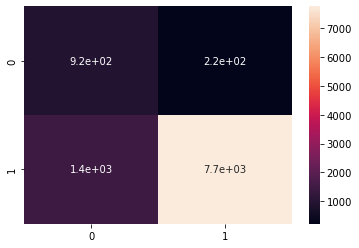

In [16]:
# Best Logistic Regression model
best_log_reg = LogisticRegression(penalty='none',fit_intercept=True,max_iter = 200)
best_log_reg.fit(train_data,train_label)
test_pred = best_log_reg.predict(test_data)
score_metrics(test_label,test_pred)

In [17]:
pickle.dump(best_log_reg,open('best_logistic_regression.sav','wb'))

Accuracy of system is  0.8759832961056618
F1 score of system is  0.8759832961056618
Confusion Matrix of system is 
 [[ 788  351]
 [ 926 8232]]


0.8759832961056618

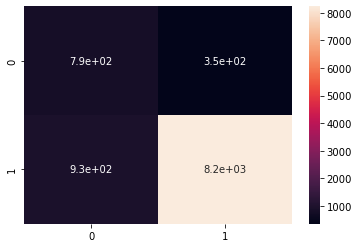

In [18]:
# Best Decision Tree model
best_dt = DecisionTreeClassifier(criterion='gini',max_depth = 6)
best_dt.fit(train_data,train_label)
test_pred = best_dt.predict(test_data)
score_metrics(test_label,test_pred)

In [19]:
pickle.dump(best_dt,open('best_decision_tree.sav','wb'))

Accuracy of system is  0.9093910847819753
F1 score of system is  0.9093910847819753
Confusion Matrix of system is 
 [[ 664  475]
 [ 458 8700]]


0.9093910847819753

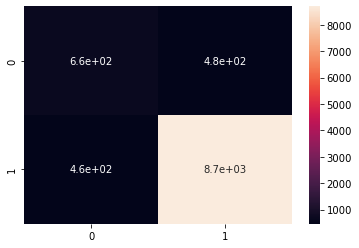

In [20]:
# Best Random Forest Model
best_rf = RandomForestClassifier(n_estimators=260,criterion='gini')
best_rf.fit(train_data,train_label)
test_pred = best_rf.predict(test_data)
score_metrics(test_label,test_pred)

In [21]:
pickle.dump(best_rf,open('best_random_forest.sav','wb'))

Accuracy of system is  0.7412838690880839
F1 score of system is  0.7412838690880839
Confusion Matrix of system is 
 [[ 995  144]
 [2520 6638]]


0.7412838690880839

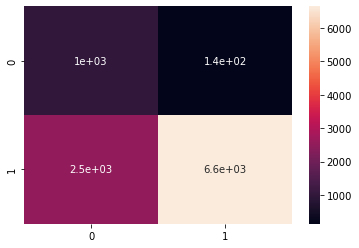

In [22]:
# Best SVM model
best_svm = LinearSVC(loss = 'squared_hinge',fit_intercept=False)
best_svm.fit(train_data,train_label)
test_pred = best_svm.predict(test_data)
score_metrics(test_label,test_pred)

In [23]:
pickle.dump(best_svm,open('best_svm_model.sav','wb'))

In [ ]:
label_prop_model = LabelPropagation()
label_prop_model.fit(total_train_data.iloc[:,:-1], total_train_data.iloc[:,-1])
label_prop_predicted = label_prop_model.predict(test_data)
score_metrics(label_prop_predicted, test_label)
pickle.dump(best_svm,open('label_prop_model.sav','wb'))

In [ ]:
label_spreading_model = LabelSpreading()
label_spreading_model.fit(total_train_data.iloc[:,:-1], total_train_data.iloc[:,-1])
label_spreading_predicted = label_spreading_model.predict(test_data)
score_metrics(label_spreading_predicted, test_label)
pickle.dump(best_svm,open('label_spread_model.sav','wb'))

# SSL

In [30]:
total_train_data = train_data.append(train_unlabelled)
total_train_label = train_label.append(pd.DataFrame(data = {'y':list(-1*np.ones(train_unlabelled.shape[0]))}).squeeze())
sh_data,sh_label = shuffle(total_train_data,total_train_label)

Accuracy of system is  0.8585024764494513
F1 score of system is  0.8585024764494513
Confusion Matrix of system is 
 [[ 888  251]
 [1206 7952]]


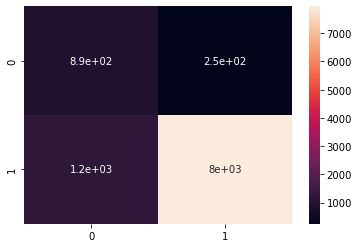

In [31]:
self_training_model = SelfTrainingClassifier(best_log_reg)
self_training_model.fit(sh_data,sh_label)
test_pred = self_training_model.predict(test_data)
score_metrics(test_label,test_pred)
pickle.dump(best_rf,open('self_training_log_reg.sav','wb'))

Accuracy of system is  0.8832669709624162
F1 score of system is  0.8832669709624162
Confusion Matrix of system is 
 [[ 856  283]
 [ 919 8239]]


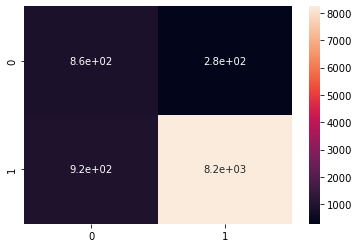

In [32]:
self_training_model = SelfTrainingClassifier(best_dt)
self_training_model.fit(sh_data,sh_label)
test_pred = self_training_model.predict(test_data)
score_metrics(test_label,test_pred)
pickle.dump(best_rf,open('self_training_decision_tree.sav','wb'))

Accuracy of system is  0.9072545401573274
F1 score of system is  0.9072545401573274
Confusion Matrix of system is 
 [[ 637  502]
 [ 453 8705]]


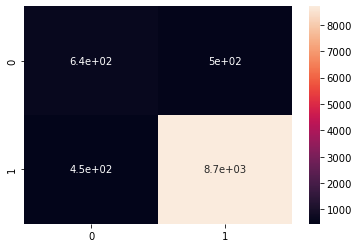

In [43]:
self_training_model = SelfTrainingClassifier(best_rf)
self_training_model.fit(sh_data,sh_label)
test_pred = self_training_model.predict(test_data)
score_metrics(test_label,test_pred)
pickle.dump(best_rf,open('self_training_random_forest.sav','wb'))

# Co Training Model

In [29]:
import mvlearn
from mvlearn.semi_supervised import CTClassifier

Accuracy of system is  0.8873458288821987
F1 score of system is  0.8873458288821986
Confusion Matrix of system is 
 [[ 863  884]
 [ 276 8274]]


0.8873458288821987

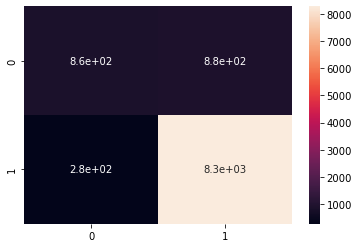

In [40]:
estimator1 = LinearSVC()
estimator2 = RandomForestClassifier()
ctc = CTClassifier(estimator1, estimator2, random_state=1)
#ctc.fit([total_train_data.iloc[:,:-1].to_numpy(), total_train_data.iloc[:,:-1].to_numpy()], total_train_data.iloc[:,-1].to_numpy())
ctc.fit([sh_data.to_numpy(),sh_data.to_numpy()],sh_label.replace([-1,0,1],[np.nan,0,1]).to_numpy())
ctc_predicted = ctc.predict([test_data.to_numpy(), test_data.to_numpy()])
score_metrics(ctc_predicted, test_label)

In [42]:
pickle.dump(ctc,open('co_training_model.sav','wb'))

# Label Propogation 

In [ ]:
label_prop_model = LabelPropagation()
label_prop_model.fit(sh_data,sh_label)
label_prop_predicted = label_prop_model.predict(test_data)
score_metrics(label_prop_predicted, test_label)

In [ ]:
pickle.dump(ctc,open('label_prop_model.sav','wb'))

# Label Spreading

In [ ]:
label_spreading_model = LabelSpreading()
label_spreading_model.fit(sh_data,sh_label)
label_spreading_predicted = label_spreading_model.predict(test_data)
score_metrics(label_spreading_predicted, test_label)

In [ ]:
pickle.dump(ctc,open('label_spread_model.sav','wb'))